In [1]:
cd /orange/adamginsburg/jwst/brick/

/blue/adamginsburg/adamginsburg/jwst/brick


In [2]:
from astropy import coordinates

In [3]:
import numpy as np

In [4]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry


In [5]:
import warnings

In [6]:
import regions

In [7]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [8]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [9]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [10]:
import glob
from astropy.io import fits

In [11]:
distance_modulus = dm = 5*np.log10(8.3*u.kpc / (10*u.pc))
dm

<Quantity 14.59539046>

In [12]:
import dust_extinction

In [13]:
from dust_extinction.parameter_averages import CCM89

In [14]:
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC

In [15]:
basepath = '/orange/adamginsburg/jwst/brick/'

basetable = Table.read(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits')

In [16]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)

/orange/adamginsburg/jwst/brick//reduction/filtering.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<module 'plot_tools' from '/orange/adamginsburg/jwst/brick//analysis/plot_tools.py'>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [17]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [18]:
any_saturated_ = [basetable[x] for x in basetable.colnames if 'near_sat' in x]
any_saturated = any_saturated_[0]
for row in any_saturated_[1:]:
    print(row.sum())
    any_saturated = any_saturated | row
any_saturated.sum()

1217
612
1778
834
4594


8216

In [19]:
magerr_gtpt1 = np.logical_or.reduce([basetable[f'emag_ab_{filtername}'] > 0.2 for filtername in filternames])
magerr_gtpt1.sum()

26025

In [20]:
oksep = np.logical_or.reduce([basetable[f'sep_{filtername}'] for filtername in filternames[1:]])
oksep.sum()

125818

In [46]:
basetable[blue_BrA_and_PaA][:2]

x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,skycoord_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,skycoord_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,skycoord_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,skycoord_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,skycoord_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,skycoord_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,Jy,,Jy,,Jy,,Jy,
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32
1621.2819835903601,5.859317479

In [94]:
blue_BrA_and_PaA = (oksep & ~any_saturated &
                    (basetable['flux_f405n'] > basetable['flux_f410m']) &
                    (basetable['flux_f187n'] > basetable['flux_f182m']) &
                    #(basetable['flux_f410m'] > 100*u.mJy) &
                    (basetable['qf_f410m'] > 0.98) &
                    (basetable['qf_f405n'] > 0.98) &
                    (basetable['spread_model_f410m'] < 0.025) &
                    (basetable['spread_model_f405n'] < 0.025) &
                    (basetable['fracflux_f410m'] > 0.9) &
                    (basetable['fracflux_f405n'] > 0.9) &
                 (~(basetable['mag_ab_f405n'].mask)) &
                 ((basetable['mag_ab_f187n'] - basetable['mag_ab_f182m']) + 
                  (basetable['emag_ab_f182m']**2 + basetable['emag_ab_f187n']**2)**0.5 < -1) &
                 ((basetable['mag_ab_f405n'] - basetable['mag_ab_f410m']) + 
                  (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -1) & ~magerr_gtpt1)
blue_BrA_and_PaA.sum()

87

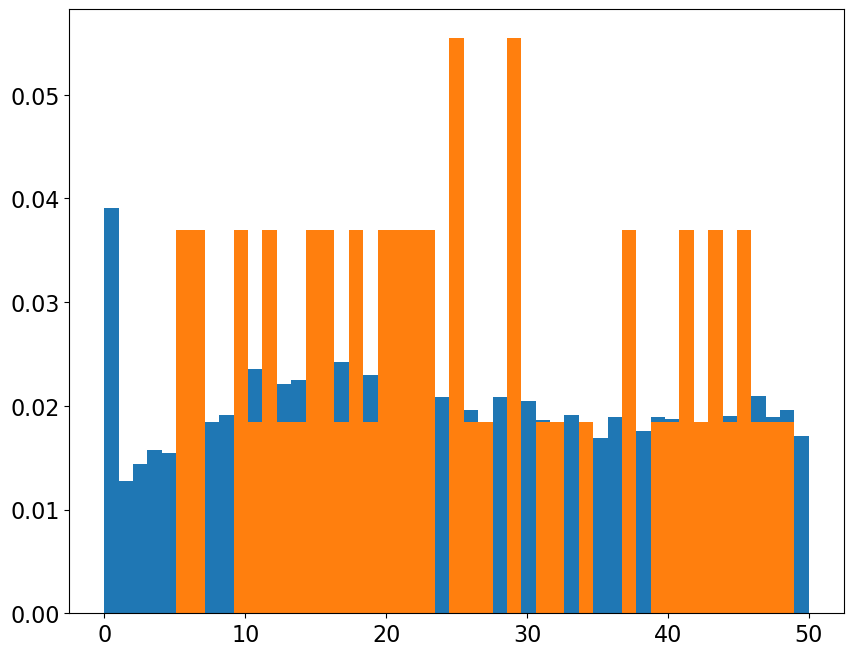

In [95]:
pl.hist(basetable['flux_f410m'] / basetable['dflux_f410m'], density=True, bins=np.linspace(0,50))
pl.hist((basetable['flux_f410m'] / basetable['dflux_f410m'])[blue_BrA_and_PaA], density=True, bins=np.linspace(0,50));

(array([171.83901673, 171.83901673, 305.37064643, 324.58480938,
        171.83901673, 267.30513713,  76.37289632, 114.51399241,
         19.09322408,  38.18644816]),
 array([3.1291387, 3.1297407, 3.1303427, 3.130945 , 3.131547 , 3.132149 ,
        3.132751 , 3.133353 , 3.1339552, 3.1345572, 3.1351593],
       dtype=float32),
 <BarContainer object of 10 artists>)

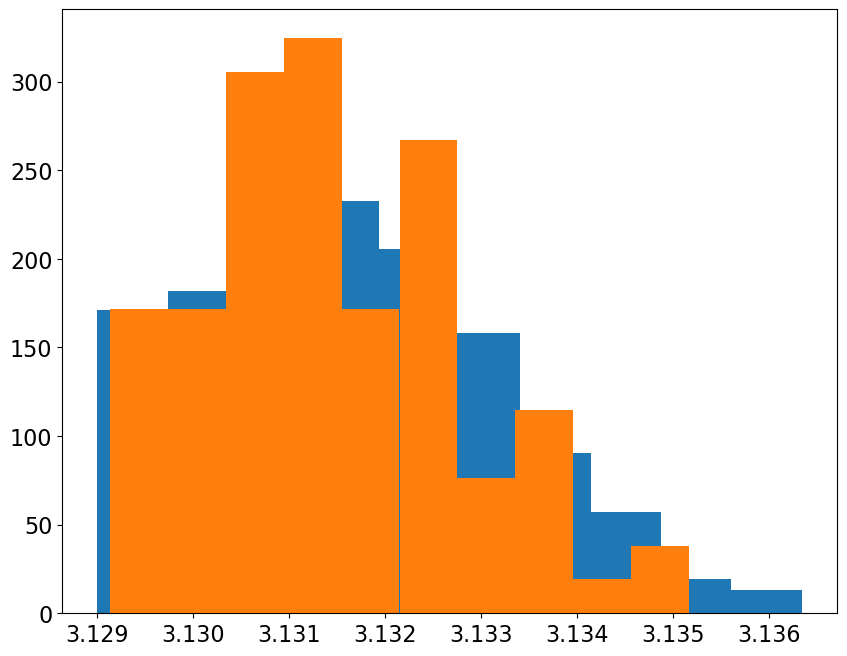

In [96]:
pl.hist(basetable['fwhm_f410m'], density=True)
pl.hist(basetable['fwhm_f410m'][blue_BrA_and_PaA], density=True)

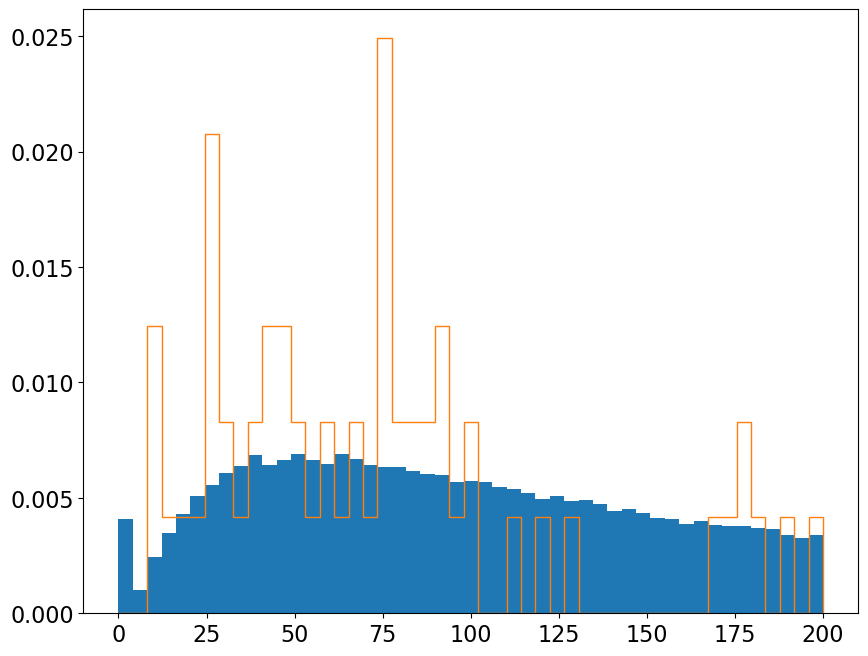

In [97]:
pl.hist(basetable['rchi2_f410m'], density=True, bins=np.linspace(0,200))
h,l,p = pl.hist(basetable['rchi2_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0,200), histtype='step');


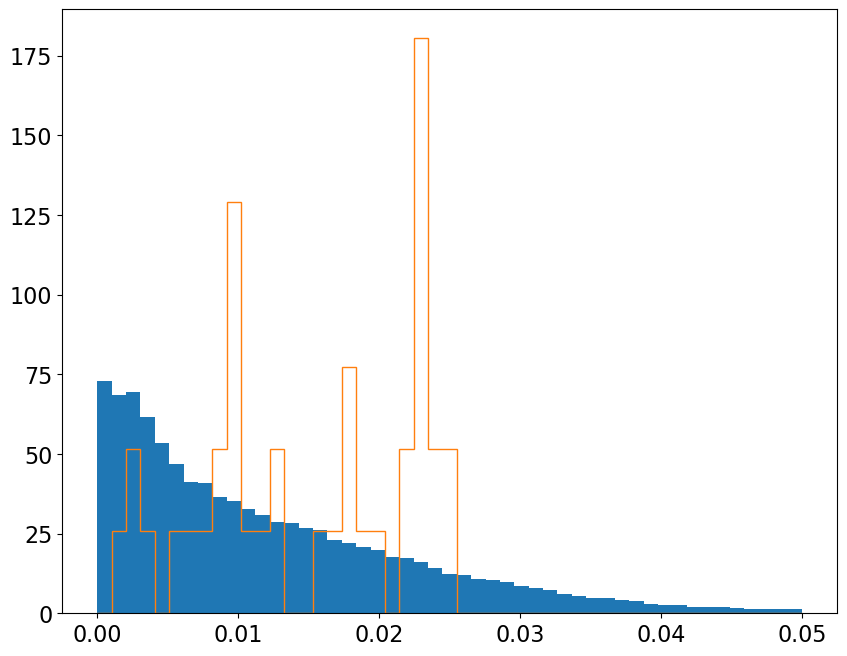

In [98]:
pl.hist(basetable['spread_model_f410m'], density=True, bins=np.linspace(0,0.05))
h,l,p = pl.hist(basetable['spread_model_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0,.05), histtype='step');

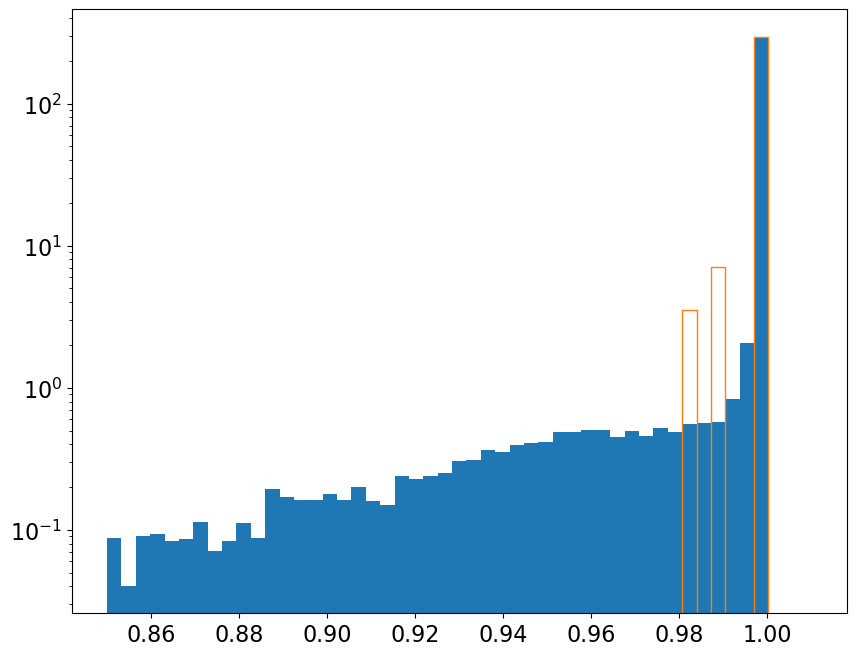

In [99]:
pl.hist(basetable['qf_f410m'], density=True, bins=np.linspace(0.85, 1.01), log=True)
pl.hist(basetable['qf_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0.85, 1.01), histtype='step', log=True);

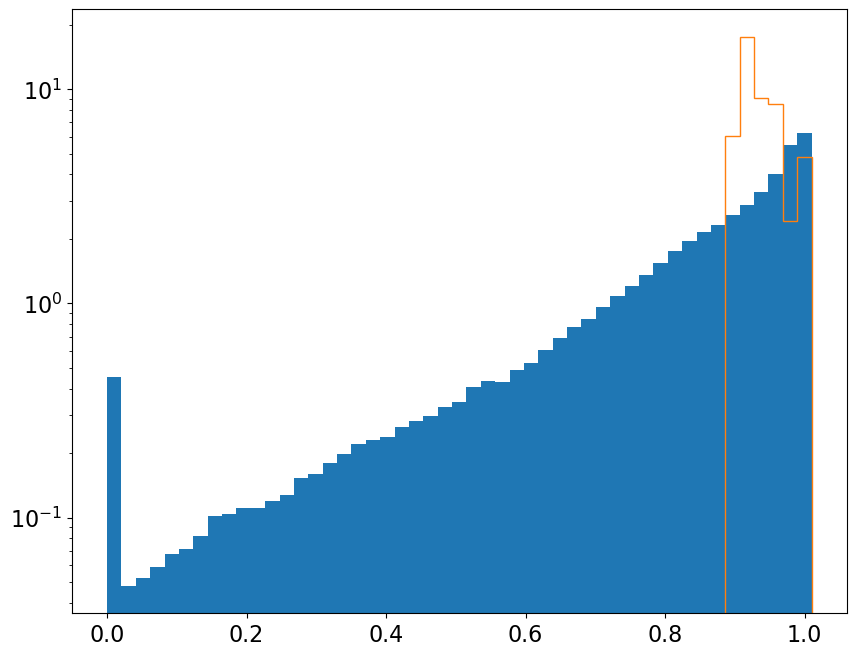

In [100]:
pl.hist(basetable['fracflux_f410m'], density=True, bins=np.linspace(0., 1.01), log=True)
pl.hist(basetable['fracflux_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0., 1.01), histtype='step', log=True);

In [101]:
basetable[blue_BrA_and_PaA].write(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged_BlueBrAandPaA.fits', overwrite=True)

In [109]:
basetable[blue_BrA_and_PaA]

x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,skycoord_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,skycoord_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,skycoord_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,skycoord_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,skycoord_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,skycoord_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,,Jy,,Jy,,Jy,,Jy,
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32
3805.6172388584287,43.56494927

In [102]:
basetable[blue_BrA_and_PaA]['skycoord_f410m'][0]

<SkyCoord (ICRS): (ra, dec) in deg
    (266.51291765, -28.69616075)>

INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [2.7096436e-05, 8.9577654e-05, 1.3996429e-04, 2.9538505e-04,
             7.9461701e-05, 1.5713213e-05] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

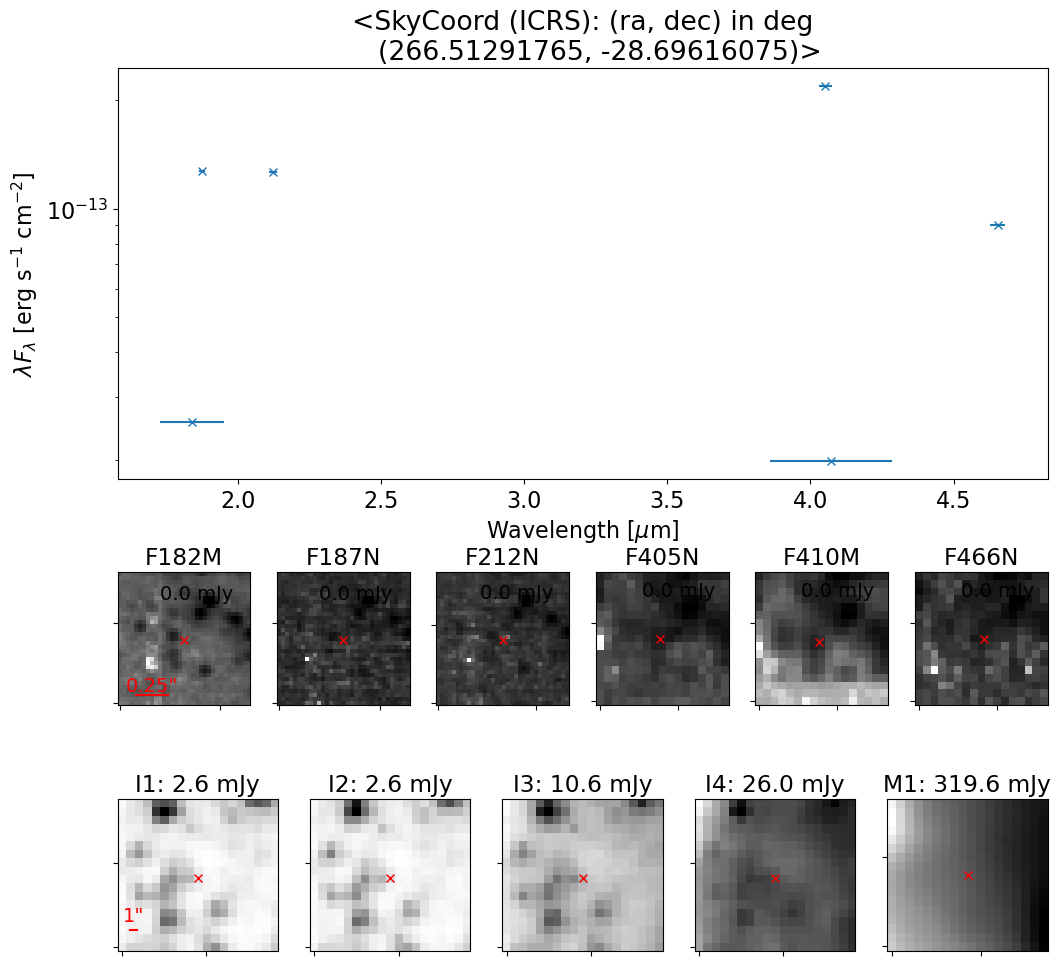

In [103]:
plot_tools.sed_and_starzoom_plot(basetable[blue_BrA_and_PaA]['skycoord_f410m'][0], basetable=basetable)

In [104]:
crd = basetable[blue_BrA_and_PaA]['skycoord_f410m'][0].galactic
f'JWST2221_G{crd.l.value:0.4f}{crd.b.value:+0.4f}'

'JWST2221_G0.2542+0.0442'

In [105]:
mkdir sed_plots

mkdir: cannot create directory ‘sed_plots’: File exists


In [106]:
from astropy import log

In [107]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)

<module 'plot_tools' from '/orange/adamginsburg/jwst/brick//analysis/plot_tools.py'>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<SkyCoord (ICRS): (ra, dec) in deg
    (266.51291765, -28.69616075)> <SkyCoord (Galactic): (l, b) in deg
    (0.25415484, 0.04422585)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51343258, -28.69436562)> <SkyCoord (Galactic): (l, b) in deg
    (0.25592289, 0.04477402)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51379749, -28.70360211)> <SkyCoord (Galactic): (l, b) in deg
    (0.24820132, 0.0396954)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51449078, -28.7380429)> <SkyCoord (Galactic): (l, b) in deg
    (0.21910458, 0.02125853)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51510193, -28.71366008

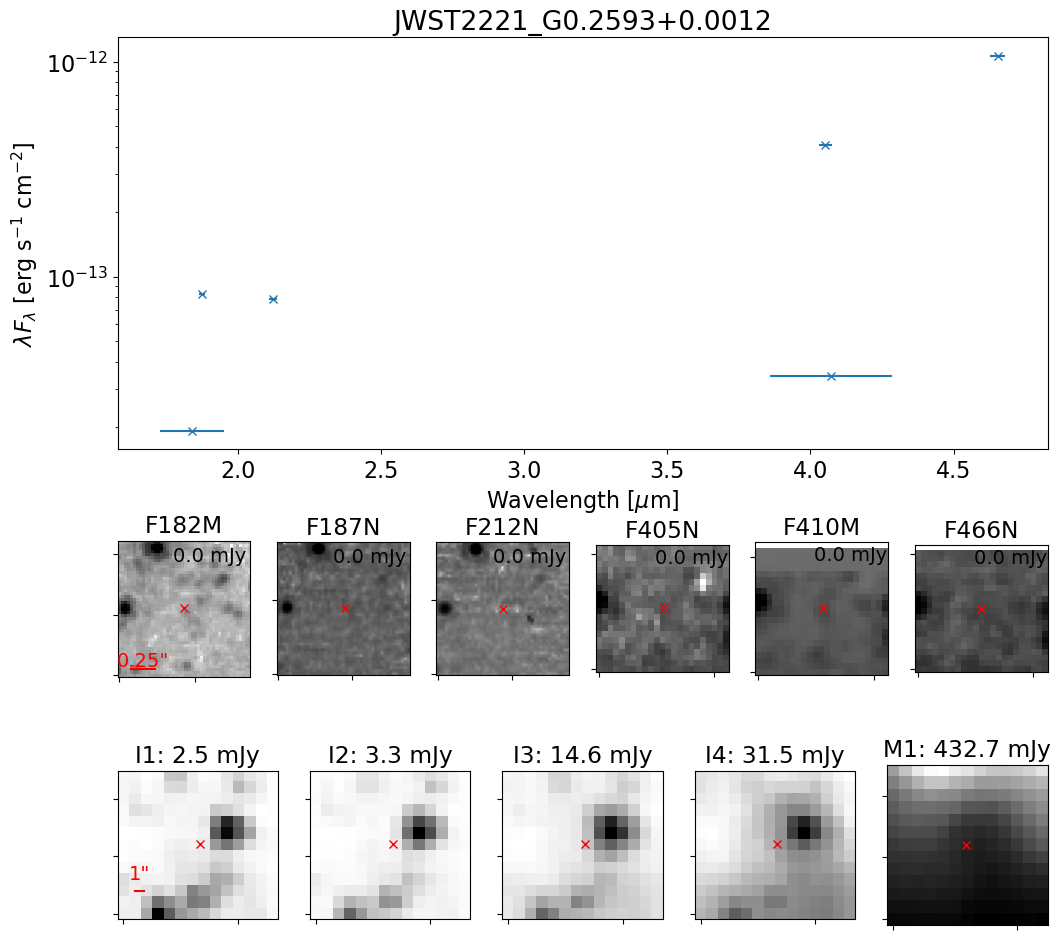

In [108]:
for crd in basetable[blue_BrA_and_PaA]['skycoord_f410m']:
    print(crd, crd.galactic)
    crd = crd.galactic
    with log.log_to_file('/dev/null'):
        name = f'JWST2221_G{crd.l.value:0.4f}{crd.b.value:+0.4f}'
        fig, _ = plot_tools.sed_and_starzoom_plot(crd, basetable=basetable, title=name)
        fig.savefig(f'{basepath}/sed_plots/{name}_SED.png', bbox_inches='tight')